In [1]:
import sys
from pathlib import Path
ROOT = next(p for p in [Path.cwd(), *Path.cwd().parents] if (p / "src").exists())
sys.path.insert(0, str(ROOT))
print("Project root:", ROOT)


Project root: c:\Users\merts\Desktop\ml_basics\credit-scoring


In [2]:
import pandas as pd, numpy as np
from src.data_prep import load_raw, basic_clean
from src.utils import DATA_RAW, PROCESSED_DIR
TARGET = "seriousdlqin2yrs"
pd.set_option("display.max_columns", 120)


In [3]:
df = basic_clean(load_raw(DATA_RAW)).copy()
df.head(3)


,seriousdlqin2yrs,revolvingutilizationofunsecuredlines,age,numberoftime30_59dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime60_89dayspastduenotworse,numberofdependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

X = df.drop(columns=[TARGET])
y = df[TARGET]
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipe_base = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler(with_mean=False)),  # numeric ağırlıklı olduğu için ok
    ("lr", LogisticRegression(max_iter=1000, class_weight="balanced"))
]).fit(Xtr, ytr)

ap_base = average_precision_score(yte, pipe_base.predict_proba(Xte)[:,1])
print("Baseline AP (ham feature'lar):", round(ap_base, 4))


Baseline AP (ham feature'lar): 0.3191


In [10]:
df_fe = df.copy()

# 1) Delinquency toplamı
cand = [c for c in df_fe.columns if "dayspastdue" in c]
if cand:
    df_fe["delinq_total"] = df_fe[cand].sum(axis=1)
    df_fe["any_delinquency"] = (df_fe["delinq_total"] > 0).astype(int)

# 2) Debtratio & Utilization: winsorize + log1p
import numpy as np
def winsorize(s, low=0.01, high=0.99):
    ql, qh = s.quantile(low), s.quantile(high)
    return s.clip(ql, qh)

if "debtratio" in df_fe.columns:
    df_fe["debtratio_w"] = winsorize(df_fe["debtratio"])
    df_fe["debtratio_log1p"] = np.log1p(df_fe["debtratio_w"])

if "revolvingutilizationofunsecuredlines" in df_fe.columns:
    u = df_fe["revolvingutilizationofunsecuredlines"]
    df_fe["util_w"] = winsorize(u)
    df_fe["util_log1p"] = np.log1p(df_fe["util_w"])

# 3) Gelir eksik mi?
if "monthlyincome" in df_fe.columns:
    df_fe["monthlyincome_missing"] = df_fe["monthlyincome"].isna().astype(int)

# 4) Yaş bandı
if "age" in df_fe.columns:
    df_fe["age_band"] = pd.cut(
        df_fe["age"],
        bins=[18,25,35,45,55,65,120],
        labels=["18-25","26-35","36-45","46-55","56-65","65+"],
        include_lowest=True
    )

# Sadece mevcut olanları göster (hata vermeden)
cols = [
    "delinq_total","any_delinquency","debtratio_log1p","util_log1p",
    "monthlyincome_missing","age_band"
]
df_fe.loc[:, [c for c in cols if c in df_fe.columns]].head()
# veya: df_fe.reindex(columns=[c for c in cols if c in df_fe.columns]).head()


,delinq_total,any_delinquency,debtratio_log1p,util_log1p,monthlyincome_missing,age_band
0,2,1,0.589442,0.568789,0,36-45
1,0,0,0.115002,0.671490,0,36-45
2,1,1,0.081684,0.505721,0,36-45
3,0,0,0.035415,0.210107,0,26-35
4,1,1,0.024620,0.645657,0,46-55


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
import pandas as pd

X = df_fe.drop(columns=[TARGET])
y = df_fe[TARGET]

# 1) Kolon tipleri
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]

# 2) Preprocessor (num: median+scaler, cat: most_frequent+OHE)
pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            # küçük kardinalite olduğu için dense çıkış güvenli
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols),
    ],
    remainder="drop"
)

# 3) Train/test
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4) Model (LR)
pipe_fe = Pipeline([
    ("pre", pre),
    ("lr", LogisticRegression(max_iter=1000, class_weight="balanced"))
]).fit(Xtr, ytr)

ap_fe = average_precision_score(yte, pipe_fe.predict_proba(Xte)[:, 1])
print("With FE AP:", round(ap_fe, 4))


With FE AP: 0.3309


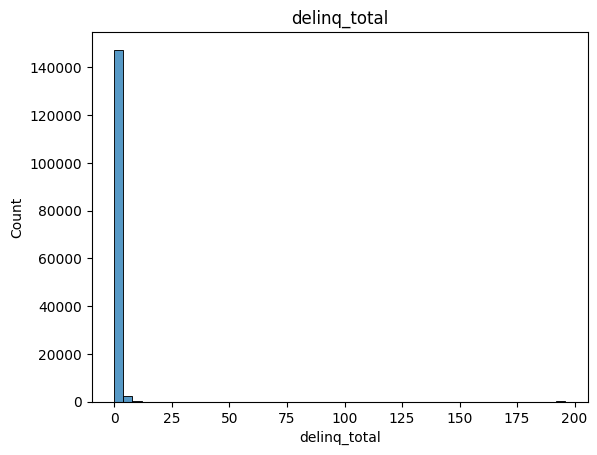

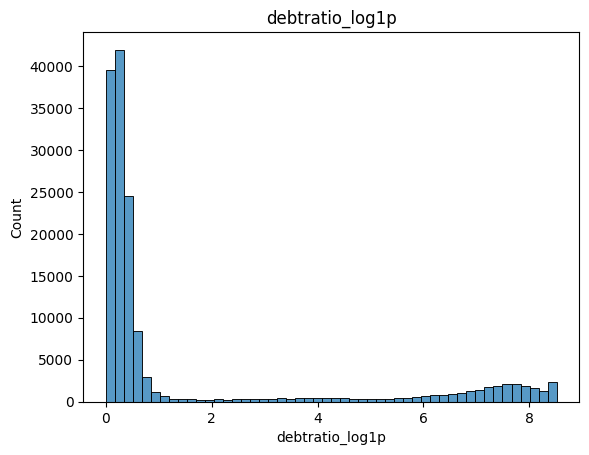

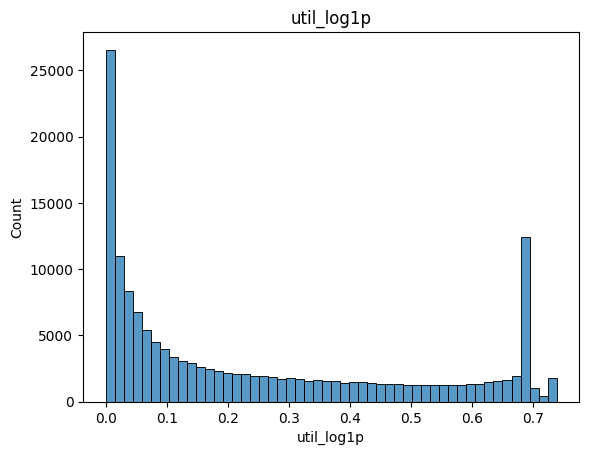

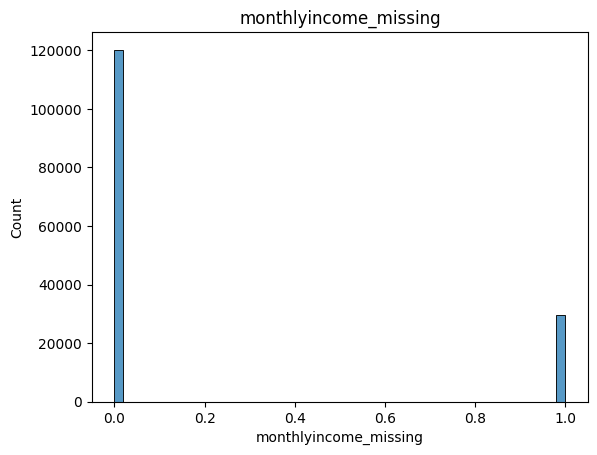

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

for c in ["delinq_total","debtratio_log1p","util_log1p","monthlyincome_missing"]:
    if c in df_fe.columns:
        sns.histplot(df_fe[c].dropna(), bins=50)
        plt.title(c); plt.show()


In [13]:
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
outp = PROCESSED_DIR / "engineered.parquet"
df_fe.to_parquet(outp, index=False)
outp


WindowsPath('C:/Users/merts/Desktop/ml_basics/credit-scoring/data/processed/engineered.parquet')